<h1>Case Study 3 - Spam vs. Ham<h1>

# Import Packages

In [1]:
import os
import pandas as pd
from bs4 import BeautifulSoup
from email import message_from_string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from email.message import Message
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define Functions For Extraction / Loading

## Extracting Content From Email

In [2]:
def extract_content_from_email(email_str):
    '''Extract the header & content from an email given as a string'''
    
    msg = message_from_string(email_str)

    # extract headers
    headers = dict(msg._headers)

    # If the email is multi-part
    if msg.is_multipart():
        content = []
        for part in msg.walk():
            content_type = part.get_content_type()
            payload = part.get_payload(decode=True)

            if payload is None:
                continue  # Skip and move on

            try:
                text = payload.decode('utf-8')
            except UnicodeDecodeError:
                try:
                    text = payload.decode('ascii')
                except:
                    text = payload.decode('ISO-8859-1')
            
            # Extract text from HTML
            if 'text/html' in content_type.lower():
                text = BeautifulSoup(text, 'lxml').get_text()

            content.append(text)
        content = ' '.join(content)
    else:
        content_type = headers.get('Content-Type', '')
        payload = msg.get_payload(decode=True)

        if payload is None:
            content = ""  # Empty string if the payload is None
        else:
            try:
                content = payload.decode('utf-8')
            except UnicodeDecodeError:
                try:
                    content = payload.decode('ascii')
                except:
                    content = payload.decode('ISO-8859-1')
            if 'text/html' in content_type.lower():
                content = BeautifulSoup(content, 'lxml').get_text()

    return headers, content

## Loading Emails From Local Folders

In [3]:
def load_emails_from_folder(folder_path, label):
    '''load and preprocess emails from folder'''
    emails = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        
        try:
            # Try reading with UTF-8 encoding first
            with open(filepath, 'r', encoding='utf-8') as f:
                email_str = f.read()
        except UnicodeDecodeError:
            try:
                # If UnicodeDecodeError, try reading with ASCII
                with open(filepath, 'r', encoding='ascii') as f:
                    email_str = f.read()
            except UnicodeDecodeError:
                # If still a UnicodeDecodeError, try ISO-8859-1
                with open(filepath, 'r', encoding='ISO-8859-1') as f:
                    email_str = f.read()
        
        headers, content = extract_content_from_email(email_str)
        emails.append({
            'headers': headers,
            'content': content,
            'label': label
        })
    return emails

def load_all_emails():
    spam_folders = ['spam', 'spam_2']
    ham_folders = ['easy_ham', 'easy_ham_2', 'hard_ham']

    spam_emails = []
    ham_emails = []

    # Load spam emails from all folders
    for folder in spam_folders:
        spam_emails.extend(load_emails_from_folder(folder, 1))

    # Load ham emails from all folders
    for folder in ham_folders:
        ham_emails.extend(load_emails_from_folder(folder, 0))

    return spam_emails, ham_emails

spam_emails, ham_emails = load_all_emails()

<h3>Spam Email and Ham Email now are two lists which contain all of the emails from the folders in the function load all emails.<h3>

## Preprocessing Text

In [4]:
all_emails = spam_emails + ham_emails

In [5]:
for i, email in enumerate(all_emails):
    count = i
    if not isinstance(email.get('content'), str):
        print(f"Index {i}, place {count} has non-string content: {email.get('content')}")

In [6]:
# Text Cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove numbers, special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [7]:
all_emails_cleaned = [clean_text(email['content']) for email in all_emails] # our x 
labels = [email['label'] for email in all_emails] # our y(target)

# Vectorization

## TfidfVectorizer
- "Term Frequency - Inverse Document Frequency"
- Vectorization technique commonly used in NLP and text analysis.
- Converts documents into a matrix of TF-IDF values. Each row represents a document, and each column represents a unique word (or n-gram) in the entire corpus. 
- Values are computed using a formula that combines term frequency(TF) with inverse document frequency(IDF). Thus, not only does it consider how often a word appears in a document (TF) but also how unique or important the wrod is accross all documents in the corpus(IDF). Common words like "The" are given lower weights, and rarer, more informative words are given higher weights. 
- TfidfVectorizer normalizes the TF-IDF values to ensure that longer documents don't have an inherent advantage in terms of TF-IDF scores.

In [8]:
tf_vectors = TfidfVectorizer()
new_vectors = tf_vectors.fit_transform(all_emails_cleaned)

In [9]:
new_vectors.shape

(9353, 85850)

# DBSCAN Clustering

In the chunk below we will iterate through to find the best eps and min samples which yield the best silhouette score.
- The Silhouette score is a metric used to calculate the goodness of a clustering algorithm. it's value ranges from -1 to 1 where a higher value indicates the object is matched well to it's own cluster and poorly matched to neighboring clusters. If most objects have high values then the clustering configuration is appropriate. if too many are low then the clustering config may have too many or too few clusters.

<h3><span style = 'color: red'>Do Not Run The Commented Out Chunk</span><h3>

In [10]:
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score
# import numpy as np

# eps_values = np.linspace(.1,2,20)
# min_samples_values = list(range(3,15))

# best_score = -1
# best_eps = None
# best_min_samples = None

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         db = DBSCAN(eps=eps, min_samples=min_samples)
#         preds = db.fit_predict(new_vectors)

#         n_clusters = len(set(preds)) -(1 if -1 in preds else 0)
#         if 1 < n_clusters < new_vectors.shape[0]:
#             score = silhouette_score(new_vectors, preds)
#             if score > best_score:
#                 best_eps, best_min_samples, best_score = eps, min_samples, score

# print(f'Best eps: {best_eps}')
# print(f'Best min_samples: {best_min_samples}')
# print(f'Best Silhouette Score: {best_score}')

Best eps: 0.8999999999999999<br><br>
Best min_samples: 3<br><br>
Best Silhouette Score: 0.05852089417844118

In [11]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = .899, min_samples = 3)
preds = db.fit_predict(new_vectors)
max(preds)

715

In [12]:
import numpy as np
from scipy.sparse import hstack
preds_matrix = np.array(preds)[:, np.newaxis]

combined_feat = hstack([new_vectors, preds_matrix])

Checking cluster counts

In [13]:
DB_df = pd.DataFrame(preds)
DB_df[0].value_counts()

-1      5578
 242     121
 15       41
 586      34
 0        28
        ... 
 150       3
 51        3
 50        3
 250       3
 715       3
Name: 0, Length: 717, dtype: int64

## DBSCAN Models

### K-Nearest Neighbors

In [14]:
X_train, X_test, y_train, y_test = train_test_split(combined_feat, labels,
                                                    test_size=.2,
                                                    random_state=12,
                                                    shuffle=True)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [16]:
predictions = knn.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.9732763228220203

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.9722073757349011

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.9641902725815072

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.977552111170497

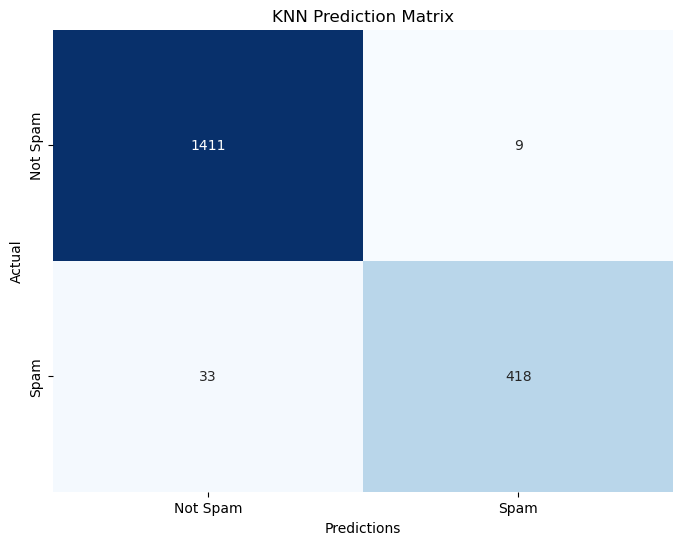

In [21]:
## Confusion Matrix
# Calculate confusion matrix
knn_matrix = confusion_matrix(y_test, predictions)

# heatmap(matrix plot)
plt.figure(figsize=(8,6))
sns.heatmap(knn_matrix, annot=True, fmt ='d',cmap = 'Blues',cbar = False,
            xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('KNN Prediction Matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, predictions)
print('KNN Classification Report:','\n',classification_rep)

KNN Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1420
           1       0.98      0.93      0.95       451

    accuracy                           0.98      1871
   macro avg       0.98      0.96      0.97      1871
weighted avg       0.98      0.98      0.98      1871



### Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)  # Convert sparse matrix to dense if necessary

# Predictions
y_pred = gnb.predict(X_test.toarray())

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print('Naive Bayes (Gaussian) Accuracy:', accuracy)

Naive Bayes (Gaussian) Accuracy: 0.9187600213789417


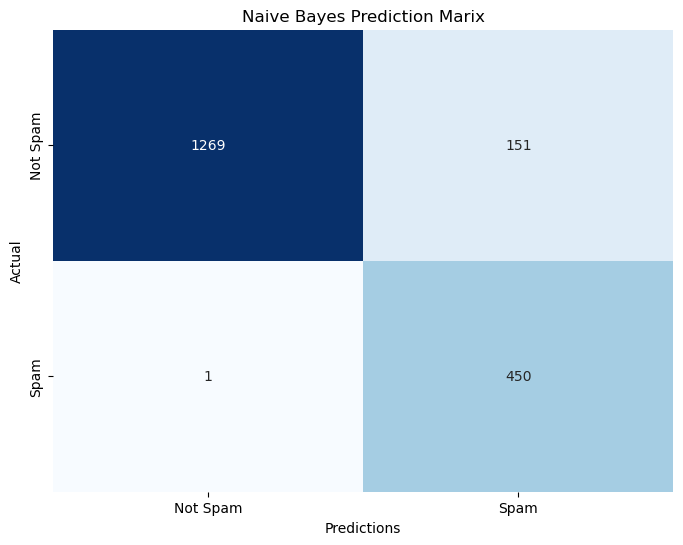

In [25]:
nb_confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(nb_confusion, annot=True, fmt = 'd', cmap = 'Blues', cbar = False,
            xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Naive Bayes Prediction Marix')
plt.show()

In [26]:
classification_rep = classification_report(y_test, y_pred)
print('Naive Bayes Classification Report:','\n',classification_rep)

Naive Bayes Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94      1420
           1       0.75      1.00      0.86       451

    accuracy                           0.92      1871
   macro avg       0.87      0.95      0.90      1871
weighted avg       0.94      0.92      0.92      1871



# K-Means

![Alt text](image.png)

![Alt text](image-1.png)

![Alt text](image-2.png)

<span style= 'color: red'> This chunk will take 65 min to run</span>

In [27]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# sil_scores = []
# max_clusters = 100
# for i in range(2, max_clusters+1):  # Silhouette score requires at least 2 clusters
#     kmeans = KMeans(n_clusters=i, tol=.0001, max_iter=300, random_state=12, n_init=10)
#     kmeans_clusters = kmeans.fit_predict(new_vectors)
#     score = silhouette_score(new_vectors, kmeans_clusters)
#     sil_scores.append(score)

# plt.figure(figsize=(10,7))
# plt.plot(range(2, max_clusters+1), sil_scores, marker='o', linestyle='--')
# plt.title('Silhouette Score Plot')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.grid(True)
# plt.show()


<span style = 'color: red'>Chunk below takes 1 hour to run<span>

In [28]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# wcss = []
# max_clusters = 100
# for i in range(1, max_clusters+1):
#     kmeans = KMeans(n_clusters=i, tol = .0001, max_iter=300, random_state=12, n_init=10)
#     kmeans.fit(new_vectors)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10,7))
# plt.plot(range(1, max_clusters+1), wcss, marker = 'o', linestyle='--')
# plt.title('Elbow Plot')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.grid(True)
# plt.show()

In [29]:
kmeans = KMeans(n_clusters=60, tol = .0001, max_iter=300)
preds = kmeans.fit_predict(new_vectors)

c:\Users\Joey\anaconda3\envs\ML\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
preds_matrix = np.array(preds)[:, np.newaxis]
combined_feat = hstack([new_vectors, preds_matrix])

## Train Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(combined_feat, labels,
                                                    test_size=.2,
                                                    random_state=12,
                                                    shuffle=True)

# K-Neighbors Classifier

*5 Nearest Neighbors*

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
predictions = knn.predict(X_test)

Old Accuracy Without The Added Clustering Feature: 0.4216996258685195

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.8097274184927846

*10 Nearest Neighbors*

Old Accuracy Without The Added Clustering Feature: 0.3201496525921967

In [35]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.7851416354890433

*3 Nearest Neighbors*

Old Accuracy Without The Added Clustering Feature: 0.5146980224478889

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.8268305718866916

*2 Nearest Neighbors*

Old Accuracy Without Added Clustering Feature: 0.8508818813468734

In [37]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
accuracy_score(y_test, predictions)

0.93425975414217

## Confusion Matrix

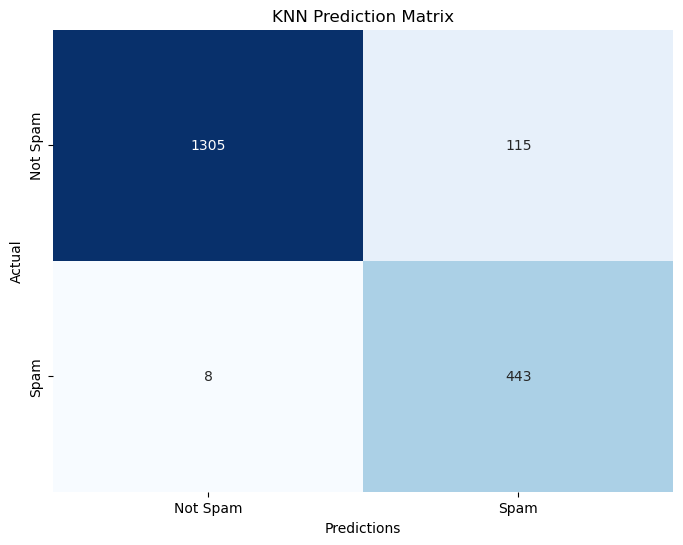

In [38]:
# Calculate confusion matrix
knn_matrix = confusion_matrix(y_test, predictions)

# heatmap(matrix plot)
plt.figure(figsize=(8,6))
sns.heatmap(knn_matrix, annot=True, fmt ='d',cmap = 'Blues',cbar = False,
            xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('KNN Prediction Matrix')
plt.show()

## Classification Report

In [39]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, predictions)
print('KNN Classification Report:','\n',classification_rep)

KNN Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      1420
           1       0.79      0.98      0.88       451

    accuracy                           0.93      1871
   macro avg       0.89      0.95      0.92      1871
weighted avg       0.95      0.93      0.94      1871



# Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()

naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [41]:
predictions = naive_bayes.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('Naive Bayes Accuracy:', accuracy)

Naive Bayes Accuracy: 0.8214858364510956


## Confusion Matrix - Naive Bayes

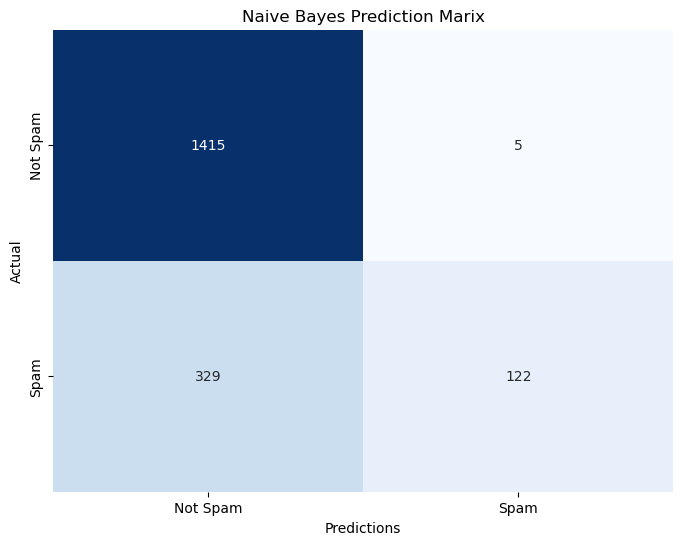

In [42]:
nb_confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8,6))
sns.heatmap(nb_confusion, annot=True, fmt = 'd', cmap = 'Blues', cbar = False,
            xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Naive Bayes Prediction Marix')
plt.show()

In [45]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, predictions)
print('Naive Bayes Classification Report:','\n',classification_rep)

Naive Bayes Classification Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      1420
           1       0.96      0.27      0.42       451

    accuracy                           0.82      1871
   macro avg       0.89      0.63      0.66      1871
weighted avg       0.85      0.82      0.78      1871

